In [1]:
%matplotlib inline
#-----Dependencies-----#

import matplotlib.pyplot as plt
import numpy as np
import keras
np.random.seed(1337)  # for reproducibility
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import Adam, SGD
import keras.backend as K
from spatial_transformer import SpatialTransformer
import cv2
import random

#-----Define global variables-----#
batch_size = 64
photo_width = 320
photo_height = 240

/Users/tommasoaldinucci/miniconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#-------BUILDING THE NETWORK-------#

input_shape = (photo_height, photo_width, 1)

# initial weights for last layer of localisation
#----At the beginning, we start with the identity transformation----#
b = np.zeros((3, 3), dtype='float32')
b[0, 0] = 1
b[1, 1] = 1
b[2, 2] = 1
W = np.zeros((int(photo_width/8)*int(photo_height/8)*20, 9), dtype='float32')
weights = [W, b.flatten()]


#-----We use just linear activation (identity function) to avoid non linear behavior of the CNN----#
#-----This is 

#-----First define the Localisation Network which will output 9 parameters for the projective transformation-----#
locnet = Sequential()
locnet.add(Convolution2D(20, (5, 5), input_shape = input_shape, padding='same'))
locnet.add(Activation('linear'))
locnet.add(MaxPooling2D(pool_size=(2,2)))
locnet.add(Convolution2D(20, (5, 5), padding='same'))
locnet.add(Activation('linear'))
locnet.add(MaxPooling2D(pool_size=(2,2)))
locnet.add(Convolution2D(20, (5, 5), padding='same'))
locnet.add(Activation('linear'))
locnet.add(MaxPooling2D(pool_size=(2,2)))
locnet.add(Flatten())
locnet.add(Dense(9, weights=weights))
locnet.add(Activation('linear'))


#-----Now we add a STN layer which will output the transformed image-----#
transf1 = Sequential()
transf1.add(SpatialTransformer(localization_net=locnet, output_size=(photo_height, photo_width, 1), input_shape=input_shape))
transf1.compile(loss='mae', optimizer='adam', metrics=['mae'])
locnet.summary()
transf1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 240, 320, 20)      520       
_________________________________________________________________
activation_1 (Activation)    (None, 240, 320, 20)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 120, 160, 20)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 160, 20)      10020     
_________________________________________________________________
activation_2 (Activation)    (None, 120, 160, 20)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 80, 20)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 80, 20)        10020     
__________

In [3]:
transf1.load_weights('weights.h5')

In [4]:
def threshhold_data(x, thresh):
    im = x
    im[im < thresh] = 0
    return im


#-----Read the testset-----#
def read_test_set(folderDatasetPath):
    import os
    
    x_set = []
    y_set = []
    lower = 35000
    for root, dirs, files in os.walk(folderDatasetPath, topdown=False): 
        for name in files:
            
            file = os.path.join(root, name)
            if file.lower().endswith(('.png', '.jpg', '.jpeg')): 
                
                x_r = cv2.imread(file, -1)
                x = cv2.resize(x_r, dsize=(photo_width,photo_height), interpolation=cv2.INTER_NEAREST)
                x = np.max(x)-x
                l = np.max(x)-300
                if l<lower:
                    lower = l
                x = threshhold_data(x, l)
                x_set.append(x)
                    
    
    
    #---Prepare the data normalizing in [0,1]. To the background is associated 0 (black), to the foreground 1---#
    #---We normalize respect to the max value of intensity (depth) of the whole dataset to preserve the depth information in each photo---#
    X_test = np.array(x_set).reshape((-1, photo_height, photo_width, 1)).astype('float32')
    X_test = (X_test - lower).astype('float32')/(np.max(X_test)-lower).astype('float32')
    X_test[X_test < 0] = 0
    
    return np.array(X_test)




In [5]:
X_test = read_test_set("dataset/test_set")
print "Shape of the test tensor: ", X_test.shape

Shape of the test tensor:  (984, 240, 320, 1)


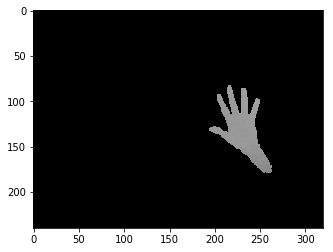

0.0 0.65762
1.0


In [54]:
p_index = 250
plt.imshow(X_test[p_index].reshape((photo_height,photo_width)), cmap='gray', vmin=0, vmax=1)
plt.show()
print np.min(X_test[p_index]), np.max(X_test[p_index])
print np.max(X_test)

In [36]:
predicts = transf1.predict(X_test)

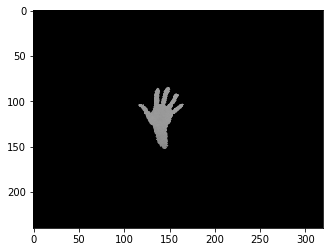

0.0 0.63997865


In [55]:
plt.imshow(predicts[p_index].reshape((photo_height,photo_width)), cmap='gray', vmin=0, vmax=1)
plt.show()
print np.min(predicts[p_index]), np.max(predicts[p_index])

In [ ]:
X1 = transf1.input
Y1 = transf1.layers[0].output
stn = K.function([X1], [Y1])


In [ ]:
test = X
res1 = np.squeeze(np.array(stn([test])))

In [ ]:
im = res1[100]
print np.min(im), np.max(im)
plt.imshow(im.reshape((240,320)), cmap='gray', vmin=0, vmax=1)
plt.show

In [ ]:
print np.min(X[800]), np.max(X[800])
print np.min(im), np.max(im)

In [ ]:
init = transf1.layers[0].locnet.input
output = transf1.layers[0].locnet.output
theta = K.function([init], [output])

#test = X[0:1000]
#res1 = np.squeeze(np.array(stn([test])))
transf_params = np.squeeze(np.array(theta([test])))
#print transf_params.shape


In [ ]:
print transf_params[200]


In [ ]:
grid_rot = np.array([[-1.20259682, -0.56366559, 0.07526565, 0.71419688, -1.21081504, -0.57188381, 0.0670474, 0.70597866, -1.21903327, -0.5801020, 0.0588292, 0.69776044, -1.22725149, -0.58832026, 0.05061098, 0.68954221],
 [-0.74833789, -0.66842914, -0.58852039, -0.50861164, -0.24803251, -0.16812376, -0.08821502, -0.00830627, 0.25227286, 0.33218161, 0.41209036, 0.49199911, 0.75257824, 0.83248698, 0.91239573, 0.99230448],
 [ 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [ ]:
width = 5
height = 5
photo_width = 160
photo_height = 120
x_ = np.linspace(-1,1,width)
y_ = np.linspace(-1,1,height)
x_c, y_c = np.meshgrid(x_, y_)
x_c = np.reshape(x_c, [-1])
y_c = np.reshape(y_c, [-1])
ones = np.ones_like(x_c)
indices_grid = np.concatenate([x_c, y_c, ones], 0).reshape((3, -1))
grid_rot = np.matmul(transf_params[800].reshape((3,3)), indices_grid)
x1 = np.min(grid_rot[0])
x2 = np.max(grid_rot[0])
y1 = np.min(grid_rot[1])
y2 = np.max(grid_rot[1])
l = x2-x1
h = y2-y1
pos_x = 10
pos_y = 20
S = np.array([[photo_width/l, 0, -photo_width*x1/l + pos_x], [0, photo_height/h, -photo_height*y1/h + pos_y], [0, 0, 1]])
drawable_grid_rot = np.matmul(S,grid_rot)
print drawable_grid_rot

In [ ]:
x_test, y_test = readDataset("dataset/test_set")

In [ ]:
x_test = np.array(x_test).reshape(-1, 180, 240, 1).astype('float32')/1500.
res1 = np.squeeze(np.array(stn([x_test])))

In [ ]:
img = res1[500]
plt.imshow(img, cmap = 'gray')
plt.show()

In [ ]:
img2 = x_test[500]
plt.imshow(img2.reshape((180,240)), cmap = 'gray')
plt.show()

In [ ]:
im = cv2.resize(cv2.imread('dataset/train_set/AldiDx_16bits/Aldidx_1.png', -1), dsize=(photo_width,photo_height), interpolation=cv2.INTER_NEAREST)

In [ ]:
print np.min(im)

In [68]:
#-----DATA PREPROCESSING----#


#-----Just set to 0 each value under the threshold-----#
def threshhold_data(x, thresh):
    im = x
    im[im < thresh] = 0
    return im



#-----Some utility methods for data augmentation-----#

#-----Makes a random rotation to the image from -30 to 30 degrees-----#
def random_rotation(x):
    theta = random.randrange(-30,30)
    rows, cols, _ = x.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),theta,1)
    dst = cv2.warpAffine(x,M,(cols,rows))
    return dst


def data_augmentation(x):
    from keras import preprocessing
    x = x.reshape((photo_height, photo_width, 1))
    x = preprocessing.image.random_zoom(x, [0.90, 1.1])
    #x = preprocessing.image.random_shear(x, 0.05)
    x = preprocessing.image.random_shift(x, 0.2, 0.2)
    x = random_rotation(x)
    return x


#-----Read the dataset for training. Add a target label for each train sample-----#
def read_train_set(folderDatasetPath):
    import os
    
    x_set = []
    y_set = []
    lower = 65000
    for root, dirs, files in os.walk(folderDatasetPath, topdown=False): 
        n = 0
        for name in files:
            
            file = os.path.join(root, name)
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                
                #-----Find the relative target for this folder-----#
                if file.lower().endswith('target.png'):
                    y_r = cv2.imread(file, -1)
                    #y = cv2.resize(y_r, dsize=(photo_width,photo_height), interpolation=cv2.INTER_NEAREST)
                    y = y_r
                    print file
                    y = np.max(y)-y
                    l = np.max(y)-300
                    if l<lower:
                        lower = l
                    y = threshhold_data(y,l)
                    y_set.append(y)
        
                else:
                    
                    x_r = cv2.imread(file, -1)
                    x = cv2.resize(x_r, dsize=(photo_width,photo_height), interpolation=cv2.INTER_NEAREST)
    
                    
                    x = np.max(x)-x
                    l = np.max(x)-300
                    if l<lower:
                        lower = l
                    
                    x = threshhold_data(x, l)
                    x_set.append(x)
                    #for i in range(2):
                        #x_set.append(data_augmentation(x))
                    n += 1
                    
                    
        #-----Now we add the target label for each train sample-----#
        for i in range(n-1):
            if y_set:
                y_set.append(y_set[len(y_set)-1])
    
    
    #---Prepare the data for fitting, normalizing in [0,1]. To the background is associated 0 (black), to the foreground 1---#
    #---We normalize respect to the max value of intensity (depth) of the whole dataset to preserve the depth information in each photo---#
    X = np.array(x_set).reshape((-1, photo_height, photo_width, 1)).astype('float32')
    y = np.array(y_set).reshape((-1, photo_height, photo_width, 1)).astype('float32')
    X = (X - lower).astype('float32')/(np.max(X)-lower).astype('float32')
    X[X < 0] = 0
    y = (y - lower).astype('float32')/(np.max(y)-lower).astype('float32')
    y[y < 0] = 0
    
    #----Prepare the validation set----#
    n_val_examples = len(X)/10
    val_indexes = random.sample([i for i in range(len(X))], n_val_examples)
    X_val = X[val_indexes]
    y_val = y[val_indexes]
    X = np.delete(X, val_indexes, axis=0)
    y = np.delete(y, val_indexes, axis=0)
    return X, y, X_val, y_val

In [69]:
#-----LOAD DATASET-----#
X, y, X_val, y_val = read_train_set("dataset/train_set")
print "Train tensor shape: ", X.shape
print "Validation tensor shape: ", X_val.shape

dataset/train_set/AldiDx_16bits/Target.png
dataset/train_set/AldiSx_16bits/Target.png
dataset/train_set/BellaDx_16bits/Target.png
dataset/train_set/BellaSx_16bits/Target.png
Train tensor shape:  (8718, 240, 320, 1)
Validation tensor shape:  (968, 240, 320, 1)


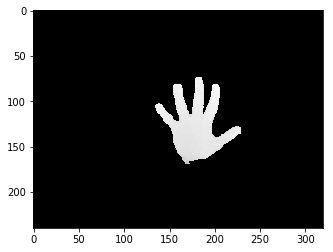

0.0 1.0


In [70]:
img2 = y[300]
plt.imshow(img2.reshape((240,320)), cmap = 'gray', vmin=0, vmax=1)
plt.show()
print np.min(img2), np.max(img2)

In [ ]:
from PIL import Image, ImageDraw, ImageShow
print np.max(Image.fromarray(X[654].reshape(photo_height, photo_width)*255.))
plt.imshow(Image.fromarray(X[654].reshape(photo_height, photo_width)*255.))
plt.show()